## POS tagging using modified Viterbi

### Data Preparation

In [131]:
#Importing libraries
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
nltk.download('treebank')
nltk.download('universal_tagset')

[nltk_data] Downloading package treebank to
[nltk_data]     /Users/Kurumbudel/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/Kurumbudel/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [132]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [133]:
# Splitting into train and test
random.seed(1234)
train_set, test_set = train_test_split(nltk_data,test_size=0.05)

print(len(train_set))
print(len(test_set))
print(train_set[:40])

3718
196
[[('By', 'ADP'), ('*-1', 'X'), ('constantly', 'ADV'), ('seeking', 'VERB'), ('*-2', 'X'), ('to', 'PRT'), ('own', 'VERB'), ('the', 'DET'), ('cheapest', 'ADJ'), ('widget', 'NOUN'), (',', '.'), ('index-arbitrage', 'ADJ'), ('traders', 'NOUN'), ('hope', 'VERB'), ('*-1', 'X'), ('to', 'PRT'), ('add', 'VERB'), ('between', 'ADP'), ('1', 'NUM'), ('%', 'NOUN'), ('and', 'CONJ'), ('3', 'NUM'), ('%', 'NOUN'), ('*U*', 'X'), ('to', 'PRT'), ('the', 'DET'), ('annual', 'ADJ'), ('return', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('S&P', 'NOUN'), ('500', 'NUM'), ('.', '.')], [('Big', 'NOUN'), ('Board', 'NOUN'), ('stock', 'NOUN'), ('specialists', 'NOUN'), (',', '.'), ('in', 'ADP'), ('a', 'DET'), ('bold', 'ADJ'), ('palace', 'NOUN'), ('revolt', 'NOUN'), (',', '.'), ('began', 'VERB'), ('shortly', 'ADV'), ('after', 'ADP'), ('Oct.', 'NOUN'), ('13', 'NUM'), ('*-1', 'X'), ('to', 'PRT'), ('telephone', 'VERB'), ('the', 'DET'), ('corporate', 'ADJ'), ('executives', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('comp

In [134]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95381

In [135]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['By',
 '*-1',
 'constantly',
 'seeking',
 '*-2',
 'to',
 'own',
 'the',
 'cheapest',
 'widget']

In [136]:
# vocabulary
V = set(tokens)
print(len(V))

12065


In [137]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [138]:
print(T)

{'CONJ', 'PRON', 'VERB', 'PRT', 'X', 'DET', 'ADV', 'ADJ', 'NOUN', 'ADP', 'NUM', '.'}


## 2. POS Tagging Algorithm - HMM

We'll use the HMM algorithm to tag the words. Given a sequence of words to be tagged, the task is to assign the most probable tag to the word. 

In other words, to every word w, assign the tag t that maximises the likelihood P(t/w). Since P(t/w) = P(w/t). P(t) / P(w), after ignoring P(w), we have to compute P(w/t) and P(t).


P(w/t) is basically the probability that given a tag (say NN), what is the probability of it being w (say 'building'). This can be computed by computing the fraction of all NNs which are equal to w, i.e. 

P(w/t) = count(w, t) / count(t). 


The term P(t) is the probability of tag t, and in a tagging task, we assume that a tag will depend only on the previous tag. In other words, the probability of a tag being NN will depend only on the previous tag t(n-1). So for e.g. if t(n-1) is a JJ, then t(n) is likely to be an NN since adjectives often precede a noun (blue coat, tall building etc.).


Given the penn treebank tagged dataset, we can compute the two terms P(w/t) and P(t) and store them in two large matrices. The matrix of P(w/t) will be sparse, since each word will not be seen with most tags ever, and those terms will thus be zero. 

### Emission Probabilities

In [139]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [140]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [141]:
# examples

# trading
print("\n", "trading")
print(word_given_tag('trading', 'ADJ'))
print(word_given_tag('trading', 'VERB'))
print(word_given_tag('trading', 'NOUN'), "\n")

# will
print("\n", "would")
print(word_given_tag('would', 'DET'))
print(word_given_tag('would', 'NOUN'))
print(word_given_tag('would', 'VERB'))

# book
print("\n", "book")
print(word_given_tag('book', 'NOUN'))
print(word_given_tag('book', 'VERB'))


 trading
(0, 6070)
(17, 12852)
(137, 27395) 


 would
(0, 8264)
(0, 27395)
(195, 12852)

 book
(6, 27395)
(1, 12852)


### Transition Probabilities

In [142]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [143]:
# examples
print(t2_given_t1(t2='PROPN', t1='ADJ'))
print(t2_given_t1('NOUN', 'ADJ'))
print(t2_given_t1('NOUN', 'DET'))
print(t2_given_t1('PROPN', 'VERB'))
print(t2_given_t1(',', 'PROPN'))
print(t2_given_t1('PRON', 'PRON'))
print(t2_given_t1('VBG', 'PROPN'))

(0, 6070)
(4250, 6070)
(5277, 8264)
(0, 12852)
(0, 0)
(20, 2603)
(0, 0)


In [144]:
#Please note P(tag|start) is same as P(tag|'.')
print(t2_given_t1('DET', '.'))
print(t2_given_t1('VERB', '.'))
print(t2_given_t1('NOUN', '.'))
print(t2_given_t1('PROPN', '.'))

(1931, 11093)
(985, 11093)
(2482, 11093)
(0, 11093)


In [145]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [146]:
tags_matrix

array([[4.68823244e-04, 6.09470233e-02, 1.55180499e-01, 5.15705580e-03,
        8.43881816e-03, 1.19081110e-01, 5.67276143e-02, 1.19081110e-01,
        3.50210965e-01, 5.20393811e-02, 4.07876223e-02, 3.18799801e-02],
       [5.37840975e-03, 7.68344197e-03, 4.85593557e-01, 1.26776798e-02,
        9.14329588e-02, 9.98847466e-03, 3.34229730e-02, 7.18401819e-02,
        2.12063000e-01, 2.18978096e-02, 6.53092563e-03, 4.14905883e-02],
       [5.21319639e-03, 3.57142873e-02, 1.68923125e-01, 3.12791802e-02,
        2.18253970e-01, 1.34920642e-01, 8.12324956e-02, 6.51260540e-02,
        1.10488638e-01, 9.09586027e-02, 2.31092442e-02, 3.47805806e-02],
       [1.97498361e-03, 1.81040149e-02, 4.02567476e-01, 1.97498361e-03,
        1.34957209e-02, 1.02040820e-01, 9.87491757e-03, 8.32784697e-02,
        2.44897962e-01, 2.10664906e-02, 5.79328500e-02, 4.27913107e-02],
       [1.03734443e-02, 5.60165979e-02, 2.05234602e-01, 1.84487715e-01,
        7.51675740e-02, 5.28247692e-02, 2.60134060e-02, 1.69

In [147]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [148]:
tags_df

,CONJ,PRON,VERB,PRT,X,DET,ADV,ADJ,NOUN,ADP,NUM,.
CONJ,0.000469,0.060947,0.155180,0.005157,0.008439,0.119081,0.056728,0.119081,0.350211,0.052039,0.040788,0.031880
PRON,0.005378,0.007683,0.485594,0.012678,0.091433,0.009988,0.033423,0.071840,0.212063,0.021898,0.006531,0.041491
VERB,0.005213,0.035714,0.168923,0.031279,0.218254,0.134921,0.081232,0.065126,0.110489,0.090959,0.023109,0.034781
PRT,0.001975,0.018104,0.402567,0.001975,0.013496,0.102041,0.009875,0.083278,0.244898,0.021066,0.057933,0.042791
X,0.010373,0.056017,0.205235,0.184488,0.075168,0.052825,0.026013,0.016917,0.062719,0.144430,0.002713,0.163102
DET,0.000484,0.003267,0.039327,0.000000,0.045620,0.005445,0.012343,0.206075,0.638553,0.009197,0.022386,0.017304
ADV,0.007307,0.014945,0.342079,0.014945,0.023248,0.068084,0.080372,0.130521,0.032215,0.118233,0.032547,0.135503
ADJ,0.016969,0.000659,0.012191,0.011038,0.020264,0.004778,0.004119,0.066227,0.700165,0.078583,0.020428,0.064580
NOUN,0.042709,0.004782,0.146852,0.043293,0.029531,0.013068,0.017010,0.012119,0.264282,0.176565,0.009418,0.240372
ADP,0.000858,0.069354,0.008361,0.001501,0.034730,0.324901,0.013935,0.106657,0.322543,0.016829,0.061957,0.038375


In [149]:
tags_df.loc['.', :]

CONJ    0.056612
PRON    0.065717
VERB    0.088795
PRT     0.002344
X       0.027405
DET     0.174074
ADV     0.053277
ADJ     0.044262
NOUN    0.223745
ADP     0.090508
NUM     0.079600
.       0.093573
Name: ., dtype: float32

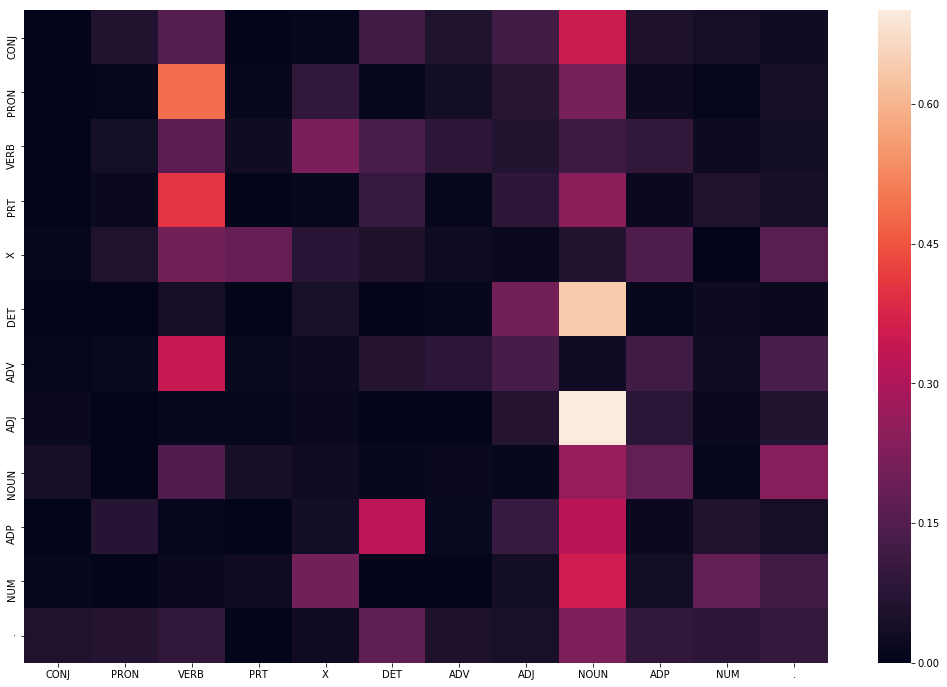

In [150]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

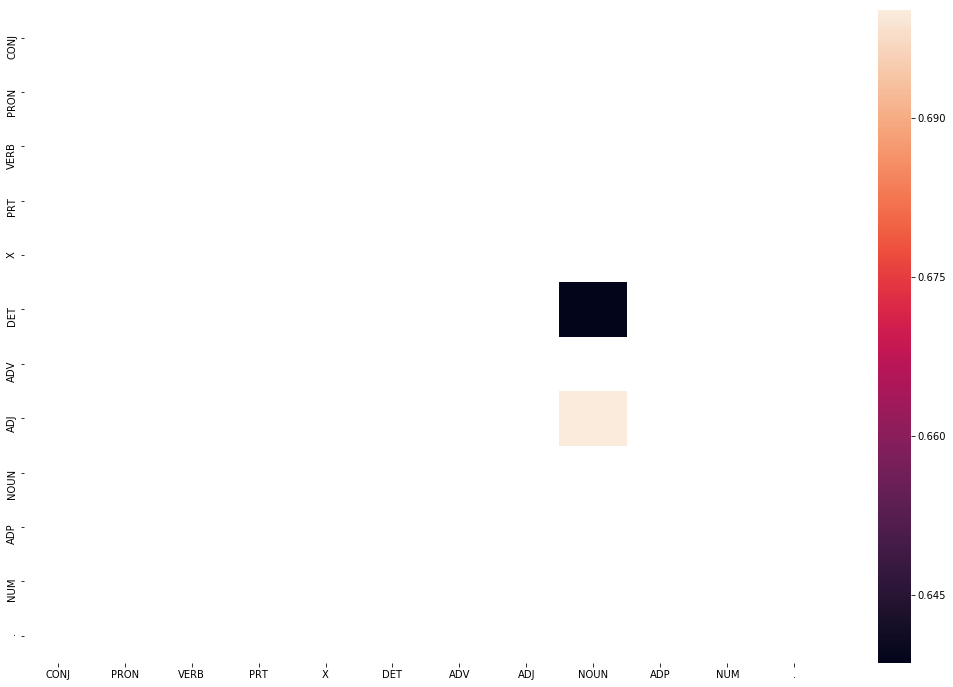

In [151]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

### Build the vanilla Viterbi based POS tagger
Let's now use the computed probabilities P(w, tag) and P(t2, t1) to assign tags to each word in the document. We'll run through each word w and compute P(tag/w)=P(w/tag).P(tag) for each tag in the tag set, and then assign the tag having the max P(tag/w).

We'll store the assigned tags in a list of tuples, similar to the list 'train_tagged_words'. Each tuple will be a (token, assigned_tag). As we progress further in the list, each tag to be assigned will use the tag of the previous token.

Note: P(tag|start) = P(tag|'.') 

In [152]:
len(train_tagged_words)

95381

In [153]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

### Evaluating on Test Set
Testing the plain Viterbi, on random sentences, full test set

In [154]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

# list of tagged words
test_run_base = [tup for sent in test_set for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_set for tup in sent]

In [155]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [156]:
print("Time taken in seconds: ", difference)
tagged_seq

Time taken in seconds:  2.384185791015625e-05


#### Evaluating tagging accuracy
Accuracy of plain Viterbi on a randomly selected set

In [157]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

In [158]:
accuracy = len(check)/len(tagged_seq)

In [159]:
accuracy

0.011378273937312151

In [160]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

In [161]:
incorrect_tagged_cases

[[('.', '.'), (('Upjohn', 'NOUN'), ('Hudson', 'NOUN'))],
 [('Hudson', 'NOUN'), ((',', '.'), ('General', 'NOUN'))],
 [('General', 'NOUN'), (('a', 'DET'), ('Corp.', 'NOUN'))],
 [('Corp.', 'NOUN'), (('rumored', 'VERB'), ("'s", 'PRT'))],
 [("'s", 'PRT'), (('target', 'NOUN'), ('president', 'NOUN'))],
 [('president', 'NOUN'), (('within', 'ADP'), ('and', 'CONJ'))],
 [('and', 'CONJ'), (('the', 'DET'), ('chief', 'ADJ'))],
 [('chief', 'ADJ'), (('drug', 'NOUN'), ('executive', 'NOUN'))],
 [('executive', 'NOUN'), (('industry', 'NOUN'), ('officer', 'NOUN'))],
 [(',', '.'), (('advanced', 'VERB'), ('Alan', 'NOUN'))],
 [('Alan', 'NOUN'), (('7\\/8', 'NUM'), ('J.', 'NOUN'))],
 [('J.', 'NOUN'), (('to', 'PRT'), ('Stearn', 'NOUN'))],
 [('Stearn', 'NOUN'), (('38', 'NUM'), (',', '.'))],
 [(',', '.'), (('7\\/8', 'NUM'), ('resigned', 'VERB'))],
 [('.', '.'), (('That', 'DET'), ('Steve', 'NOUN'))],
 [('Steve', 'NOUN'), (('followed', 'VERB'), ('Martin', 'NOUN'))],
 [('Martin', 'NOUN'), (('four', 'NUM'), ('has', 'V

In [162]:
## Testing
#nltk.download('punkt')
#sentence_test = 'Twitter is the best networking social site. Man is a social animal. Data science is an emerging field. Data science jobs are high in demand.'
#words = word_tokenize(sentence_test)

#start = time.time()
#tagged_seq = Viterbi(words)
#end = time.time()
#difference = end-start

In [163]:
#print(tagged_seq)
#print(difference)

### Solve the problem of unknown words
Now it is time ot solve the problem of unknown words. I am trying few methods like Regex and Lexicon processing

In [164]:
# splitting into train and test
random.seed(1234)
train_set_lex, test_set_lex = train_test_split(nltk_data, test_size=0.05)

print(len(train_set_lex))
print(len(test_set_lex))
print(test_set_lex[:2])

3718
196
[[('Among', 'ADP'), ('segments', 'NOUN'), ('that', 'DET'), ('*T*-1', 'X'), ('continue', 'VERB'), ('*-2', 'X'), ('to', 'PRT'), ('operate', 'VERB'), (',', '.'), ('though', 'ADV'), (',', '.'), ('the', 'DET'), ('company', 'NOUN'), ("'s", 'PRT'), ('steel', 'NOUN'), ('division', 'NOUN'), ('continued', 'VERB'), ('*-3', 'X'), ('to', 'PRT'), ('suffer', 'VERB'), ('from', 'ADP'), ('soft', 'ADJ'), ('demand', 'NOUN'), ('for', 'ADP'), ('its', 'PRON'), ('tubular', 'ADJ'), ('goods', 'NOUN'), ('serving', 'VERB'), ('the', 'DET'), ('oil', 'NOUN'), ('industry', 'NOUN'), ('and', 'CONJ'), ('other', 'ADJ'), ('markets', 'NOUN'), ('.', '.')], [('Still', 'ADV'), (',', '.'), ('some', 'DET'), ('market', 'NOUN'), ('analysts', 'NOUN'), ('say', 'VERB'), ('0', 'X'), ('the', 'DET'), ('current', 'ADJ'), ('3.3', 'NUM'), ('%', 'NOUN'), ('reading', 'NOUN'), ('is', 'VERB'), ("n't", 'ADV'), ('as', 'ADV'), ('troublesome', 'ADJ'), ('as', 'ADP'), ('it', 'PRON'), ('might', 'VERB'), ('have', 'VERB'), ('been', 'VERB'), (

In [165]:
# Lexicon (or unigram tagger)
unigram_tagger = nltk.UnigramTagger(train_set_lex)
unigram_tagger.evaluate(test_set)

0.9722379603399434

The above is the accuracy of Unigram tagger. Now let us combine the Lexicon and Viterbi

In [211]:
# Lexicon (or unigram tagger)
def unigram_tagger_custom(word):
    #unigram_tagger_2 = nltk.UnigramTagger(train_set_lex)
    return unigram_tagger.tag([word])[0][1]

In [240]:
# Modifying Viterbi with Lexicon processing 
def Viterbi_Modified_with_unigram(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    x=0
    for key, word in enumerate(words):
        if word not in train_bag[x]:
            #initialise list of probability column for a given observation
            p = [] 
            for tag in T:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                
                # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
            state.append(state_max)
        else:
            state.append(unigram_tagger_custom(word))
        x=x+1
   
    return list(zip(words, state))

In [241]:
test_run_base = [tup for sent in test_set for tup in sent]
# list of untagged words
test_tagged_words = [tup[0] for sent in test_set for tup in sent]

# tagging the test sentences
start = time.time()
tagged_seq_modified = Viterbi_Modified_with_unigram(test_tagged_words)
end = time.time()
difference = end-start

#### Evaluating tagging accuracy with modified with Lexicon processing

In [242]:
print("Time taken in seconds: ", difference)
# accuracy
check = [i for i, j in zip(tagged_seq_modified, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq_modified)
accuracy

Time taken in seconds:  1098.6509342193604


0.904438149197356

### Regex processing

In [248]:
# Now I am using Regex to define few rules for the incorrectly tagged words, which will increase the accuracy
# specify patterns for tagging
# example from the NLTK book
patterns = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # Verb, past tense
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # numbers
    (r'Android$', 'NOUN'),            # nouns
    (r'Google$', 'NOUN'),             # nouns
    (r'FIFA$', 'NOUN'),               # nouns
    (r'.*-*$', 'NOUN'),               # nouns
    (r'.*es$', 'VERB'),                 # Verb
    (r'.*age$', 'NOUN')
]
regexp_tagger = nltk.RegexpTagger(patterns)

In [256]:
def regex_tagger_custom(word):
    return regexp_tagger.tag([word])[0][1]

In [254]:
# Viterbi Heuristic with regex
def Viterbi_modified_with_regex(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    x = 0;
    for key, word in enumerate(words):
        if word not in incorrect_tagged_cases:
            #initialise list of probability column for a given observation
            p = [] 
            for tag in T:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                
                # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)
        
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
            state.append(state_max)
        else:
            state.append(regex_tagger_custom(word))
        x = x+1
    
    return list(zip(words, state))

### Evaluate the accuracy

In [255]:
random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]
test_run_base = [tup for sent in test_run for tup in sent]
# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]

# tagging the test sentences
start = time.time()
tagged_seq_modifiedRegex = Viterbi_modified_with_regex(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)
# accuracy
check = [i for i, j in zip(tagged_seq_modifiedRegex, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq_modifiedRegex)
accuracy

Time taken in seconds:  30.49448299407959


0.8904109589041096

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

Tagging accuracy with Vanilla Viterbi is 91%

Accuracy with Modified Vanilla with Lexicon is 90%

Accuracy with Modified Vanilla with Regex is 89% on random set

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

While using Regex, it tagged the nouns correcly with has "-" in between
it tagged the words ending with 'age' correctly

With Lexicon, it tagged the words which were unknown with just Vanilla Viterbi